# TP : Comprendre la Convolution

Ce TP guide une exploration progressive de la convolution 2D en partant de manipulations NumPy explicites avant de reproduire les mêmes opérations avec PyTorch. 

Vous analyserez chaque étape, depuis la sélection des sous-matrices jusqu'à l'obtention des cartes de caractéristiques, afin de consolider les fondements théoriques qui soutiennent les réseaux de neurones convolutionnels.


### Mettre en place les dépendances

Importez les bibliothèques indispensables pour la séance :
- `numpy` afin de manipuler les tenseurs sous forme de tableaux
- `matplotlib.pyplot` pour les visualisations matricielles
- `matplotlib.patches.Rectangle` pour mettre en évidence les régions d'intérêt dans les figures


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

### Visualiser une matrice annotée

La fonction `plot_matrix_with_rectangle(matrix, title="Matrix", rect_size=(0,0), rect_coords=(0,0))` vous est donnée. 
Elle affiche une matrice sous forme de grille avec ses valeurs numériques et permet de mettre en évidence une région rectangulaire spécifique à l'aide d'un cadre bleu. 

**Paramètres :**
- `matrix` (np.ndarray) : La matrice à afficher
- `title` (str, optional) : Titre du graphique (par défaut "Matrix")
- `rect_size` (tuple) : (largeur, hauteur) du rectangle à tracer
- `rect_coords` (tuple) : (x, y) coordonnées du coin supérieur gauche du rectangle

Cette visualisation facilitera la compréhension des opérations de convolution en montrant clairement quelle zone de l'image est traitée par le filtre à un instant donné.


In [ ]:
def plot_matrix_with_rectangle(matrix, title="Matrix", rect_size=(0,0), rect_coords=(0,0)):
    """
    Affiche une matrice avec un rectangle autour d'une sous-matrice spécifiée.

    Args:
        matrix (np.ndarray): La matrice à afficher.
        rect_size (tuple): (largeur, hauteur) du rectangle.
        rect_coords (tuple): (x, y) coordonnées du coin supérieur gauche du rectangle.
        title (str, optional): Titre du graphique.
    """
    fig, ax = plt.subplots(figsize=tuple(np.array(matrix.shape)/2.2))
    if title:
        ax.set_title(title, fontsize=16)
    nrows, ncols = matrix.shape
    ax.set_xlim(0, ncols)
    ax.set_ylim(0, nrows)
    ax.set_aspect('equal', adjustable='box')

    for i in range(nrows + 1):
        ax.axhline(i, color='grey', linestyle=':', linewidth=1)
    for j in range(ncols + 1):
        ax.axvline(j, color='grey', linestyle=':', linewidth=1)

    for i in range(nrows):
        for j in range(ncols):
            ax.text(j + 0.5, nrows - (i + 0.5), str(matrix[i, j]),
                    ha='center', va='center', fontsize=12, fontweight='light')

    row, col = rect_coords
    rect_width, rect_height = rect_size
    rect = Rectangle((col, nrows - row - rect_height), rect_width, rect_height, linewidth=3, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    plt.show()


In [9]:
def plot_matrix_without_rectangle(matrix, title="Matrix"):
    """
    Affiche une matrice avec un rectangle autour d'une sous-matrice spécifiée.

    Args:
        matrix (np.ndarray): La matrice à afficher.
        title (str, optional): Titre du graphique.
    """
    fig, ax = plt.subplots(figsize=tuple(np.array(matrix.shape)/2.2))
    if title:
        ax.set_title(title, fontsize=16)
    nrows, ncols = matrix.shape
    ax.set_xlim(0, ncols)
    ax.set_ylim(0, nrows)
    # ax.set_aspect('equal', adjustable='box')

    for i in range(nrows + 1):
        ax.axhline(i, color='grey', linestyle=':', linewidth=1)
    for j in range(ncols + 1):
        ax.axvline(j, color='grey', linestyle=':', linewidth=1)

    for i in range(nrows):
        for j in range(ncols):
            ax.text(j + 0.5, nrows - (i + 0.5), str(matrix[i, j]),
                    ha='center', va='center', fontsize=12, fontweight='light')
    ax.axis('off')
    plt.show()

### Illustrer la visualisation matricielle

Construisez une matrice NumPy d'exemple, puis appelez `plot_matrix_with_rectangle` afin de vérifier que la fenêtre sélectionnée est correctement mise en évidence et que les valeurs sont lisibles sur la figure.


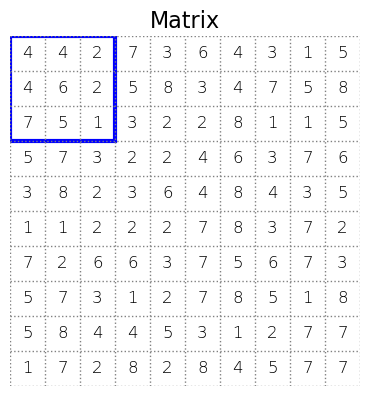

In [41]:
data = np.array([[np.random.randint(1, 9) for _ in range(10)] for _ in range(10)])

plot_matrix_with_rectangle(data, "Matrix", rect_size=(3, 3), rect_coords=(0, 0))

### Extraire une fenêtre de convolution

Développez la fonction `extract_submatrix(matrix, kernel_size, top_left, verbose=True)`.

Cette fonction doit extraire une région rectangulaire de la matrice d'entrée en utilisant les indices spécifiés. 

Lorsque `verbose=True`, elle doit :
1. Afficher la matrice originale avec un rectangle bleu délimitant la zone à extraire
2. Afficher séparément la sous-matrice extraite pour faciliter l'analyse

Cette extraction simule le déplacement d'une fenêtre glissante sur l'image, opération fondamentale de la convolution 2D.

**Paramètres :**
- `matrix` (np.ndarray) : La matrice d'entrée représentant l'image source à traiter
- `kernel_size` (tuple) : Un tuple `(largeur, hauteur)` spécifiant les dimensions du filtre de convolution à appliquer
- `top_left` (tuple) : Un tuple `(row, col)` indiquant les coordonnées du coin supérieur gauche de la zone à extraire
- `verbose` (bool, optional) : Si `True`, affiche visuellement la matrice originale avec la région d'extraction mise en évidence ainsi que la sous-matrice extraite (par défaut `True`)

**Retour :**
- `np.ndarray` : La sous-matrice extraite correspondant à la fenêtre de convolution

**Comportement attendu :**



In [47]:
def extract_submatrix(matrix, kernel_size, top_left, verbose=True):
    """
    Extrait une sous-matrice d'une matrice donnée.

    Args:
        matrix (np.ndarray): La matrice source.
        top_left (tuple): (x, y) coordonnées du coin supérieur gauche de la sous-matrice.
        size (tuple): (largeur, hauteur) de la sous-matrice.
        verbose (bool): Si True, affiche les matrices.

    Returns:
        np.ndarray: La sous-matrice extraite.
    """
    if verbose:
        plot_matrix_with_rectangle(matrix, "Original", rect_size=kernel_size, rect_coords=top_left)
        plot_matrix_without_rectangle(matrix[top_left[0]:top_left[0]+kernel_size[0],top_left[1]:top_left[1]+kernel_size[1]], "Extracted")
        return matrix[top_left[0]:top_left[0]+kernel_size[0],top_left[1]:top_left[1]+kernel_size[1]]
    else:
        plot_matrix_without_rectangle(matrix, "Original")
        return None

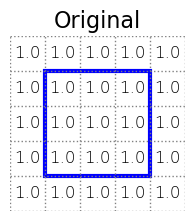

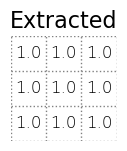

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [14]:
# Exemple d'extraction de sous-matrice
extracted = extract_submatrix(data, (3, 3), (1, 1), verbose=True)
display(extracted)

### Définir et visualiser un filtre

Créez un filtre 2D représentatif sous forme de matrice NumPy et affichez-le avec `plot_matrix_with_rectangle`.


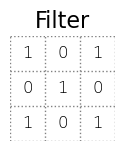

In [12]:
filter = np.array([
    [1,0,1],
    [0,1,0],
    [1,0,1]
])
plot_matrix_with_rectangle(filter, title="Filter")

### Appliquer un filtre sur une position donnée

Complétez la fonction `apply_filter(matrix, filter, position, verbose=True)` qui réalise l'opération fondamentale de convolution sur une fenêtre locale :

1. **Extraction de la fenêtre** : À partir de la `position` spécifiée (coin supérieur gauche), utilisez `extract_submatrix` pour prélever une région de même dimension que le filtre
2. **Multiplication élément par élément** : Appliquez l'opérateur de Hadamard (multiplication terme à terme) entre la sous-matrice extraite et le filtre
3. **Agrégation** : Sommez tous les produits obtenus pour produire une valeur scalaire unique qui constitue la réponse du filtre à cette position
4. **Visualisation conditionnelle** : Si `verbose=True`, affichez successivement :
    - La matrice d'entrée avec la fenêtre traitée mise en évidence
    - La sous-matrice extraite
    - Le filtre appliqué
    - Le résultat scalaire final

**Paramètres :**
- `matrix` (np.ndarray) : La matrice source sur laquelle appliquer le filtre
- `filter` (np.ndarray) : Le noyau de convolution (kernel) contenant les poids
- `position` (tuple) : Coordonnées `(row, col)` du coin supérieur gauche de la fenêtre à traiter
- `verbose` (bool, optional) : Active l'affichage détaillé des étapes intermédiaires (par défaut `True`)

**Retour :**
- `float` : La valeur scalaire résultant de la convolution locale

Cette fonction simule le calcul d'un seul pixel dans la carte de caractéristiques finale, opération qui sera répétée pour toutes les positions valides lors de la convolution complète.


In [48]:
def apply_filter(matrix, filter, position, verbose=True):
    """
    Applique un filtre à une matrice à une position donnée.

    Args:
        matrix (np.ndarray): La matrice source.
        filter (np.ndarray): Le filtre à appliquer.
        position (tuple): (row, col) coordonnées du coin supérieur gauche où appliquer le filtre.
        verbose (bool): Si True, affiche les matrices.

    Returns:
        float: Le résultat de l'application du filtre.
    """
    extract=extract_submatrix(matrix,filter.shape,position,verbose)
    if extract is not None:
        value=(extract*filter).sum()
        plot_matrix_without_rectangle(filter,"Filter")
        plot_matrix_without_rectangle(np.array([[value]]),"Result")
        return value
    return 0.0

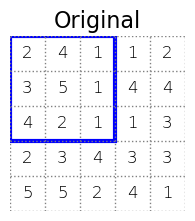

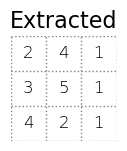

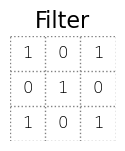

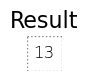

np.int64(13)

In [49]:
# Exemple d'utilisation de l'application de filtre
result = apply_filter(data, filter, (0, 0), verbose=True)
display(result)

### Déplacer la fenêtre de convolution

Réutilisez `apply_filter` en translatant la fenêtre d'un pas vers la droite tout en conservant l'affichage détaillé, puis comparez la valeur calculée avec celle du précédent appel pour comprendre l'effet d'un déplacement spatial.


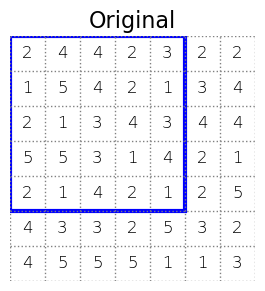

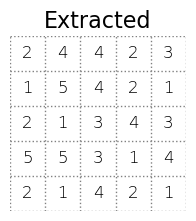

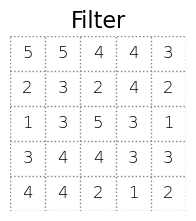

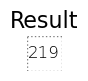

np.int64(219)

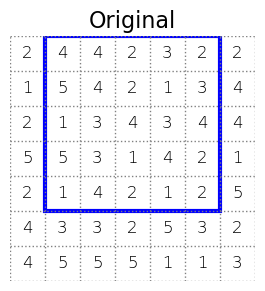

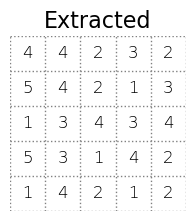

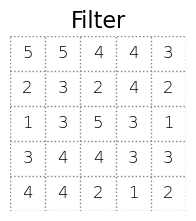

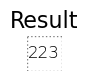

np.int64(223)

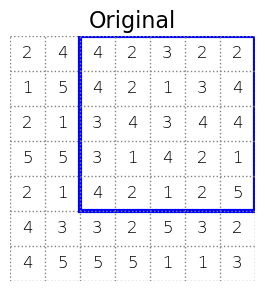

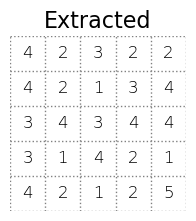

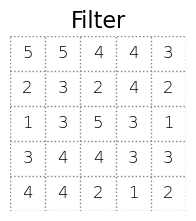

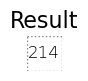

np.int64(214)

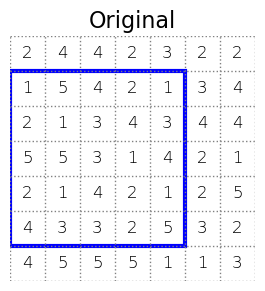

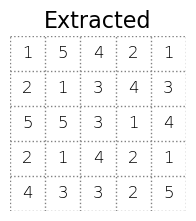

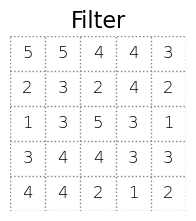

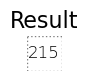

np.int64(215)

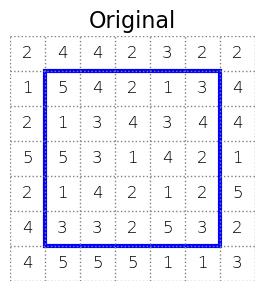

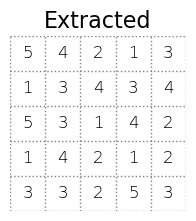

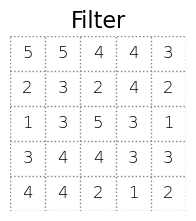

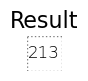

np.int64(213)

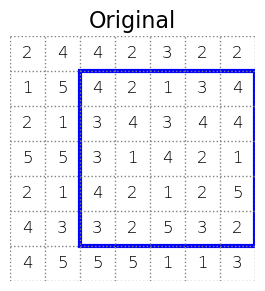

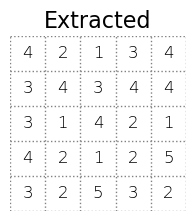

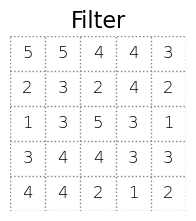

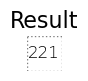

np.int64(221)

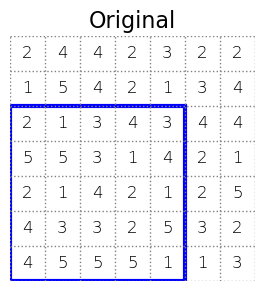

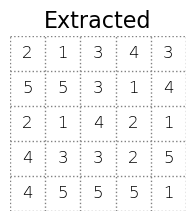

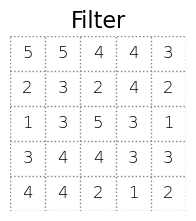

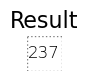

np.int64(237)

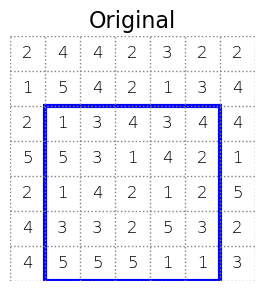

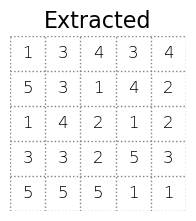

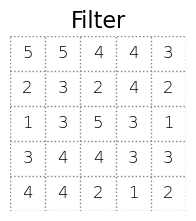

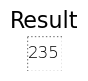

np.int64(235)

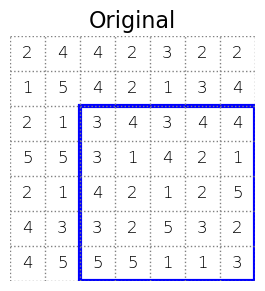

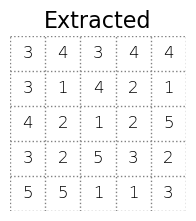

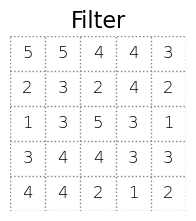

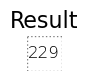

np.int64(229)

In [56]:
from math import ceil
data=np.array([[np.random.randint(1,6) for _ in range(7)] for i in range(7)])
filter=np.array([[ ceil(5*np.random.uniform(0,1)) for _ in range(5)] for _ in range(5)])
for i in range(data.shape[0]-(filter.shape[0]//2)*2):
    for j in range(data.shape[1]-(filter.shape[1]//2)*2):
        value=apply_filter(data,filter,(i,j),True)
        display(value)

### Mettre en œuvre la convolution complète

Créez la fonction `convolution(matrix, filter, verbose=True)` qui réalise une convolution 2D complète en faisant glisser systématiquement le filtre sur toutes les positions valides de la matrice d'entrée.

**Affichage conditionnel** : Si `verbose=True`, affichez les étapes intermédiaires de chaque application du filtre (extraction, multiplication, sommation) pour comprendre le processus en détail

**Paramètres :**
- `matrix` (np.ndarray) : La matrice d'entrée représentant l'image à convoluer
- `filter` (np.ndarray) : Le noyau de convolution à appliquer
- `verbose` (bool, optional) : Active l'affichage détaillé de chaque étape de convolution (par défaut `True`)

**Retour :**
- `np.ndarray` : La carte de caractéristiques résultante après application du filtre sur toute la matrice

In [66]:
def convolution(matrix, filter, verbose=True):
    """
    Applique une convolution complète d'une matrice avec un filtre donné.

    Args:
        matrix (np.ndarray): La matrice source.
        filter (np.ndarray): Le filtre à appliquer.
        verbose (bool): Si True, affiche les matrices.

    Returns:
        np.ndarray: La matrice résultante après convolution complète.
    """
    result=[]
    for i in range(matrix.shape[0]-(filter.shape[0]//2)*2):
        tmp=[]
        for j in range(matrix.shape[1]-(filter.shape[1]//2)*2):
            value=apply_filter(matrix,filter,(i,j),verbose)
            tmp.append(value)
            display(value)
        result.append(tmp)
    return np.array(result)
            

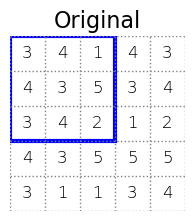

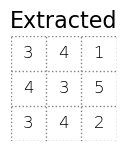

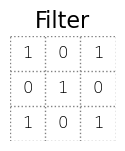

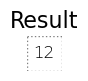

np.int64(12)

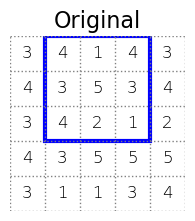

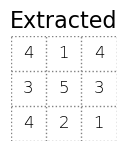

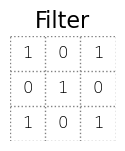

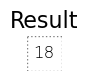

np.int64(18)

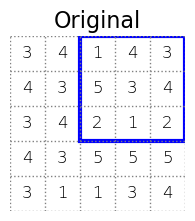

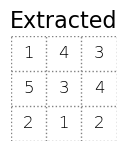

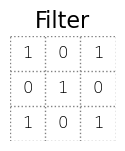

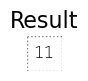

np.int64(11)

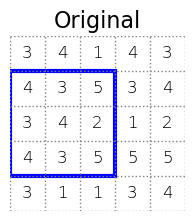

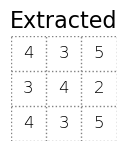

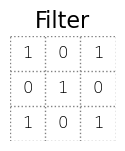

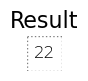

np.int64(22)

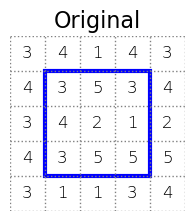

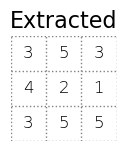

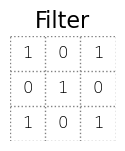

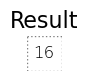

np.int64(16)

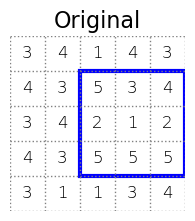

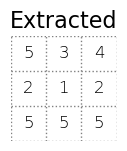

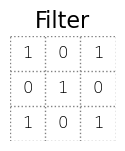

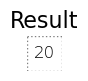

np.int64(20)

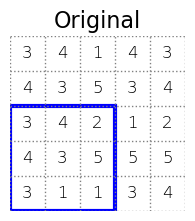

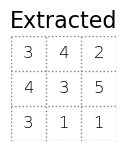

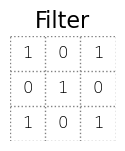

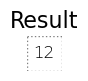

np.int64(12)

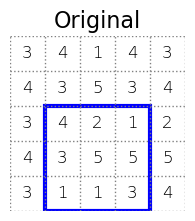

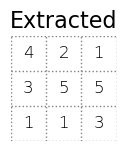

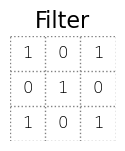

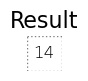

np.int64(14)

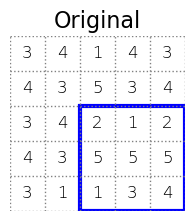

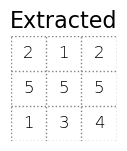

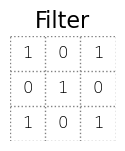

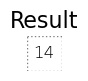

np.int64(14)

array([[12, 18, 11],
       [22, 16, 20],
       [12, 14, 14]])

In [ ]:
data=np.random.randint(1,6,size=(5,5))
filter=np.array([
    [ 1,0,1],
    [ 0,1,0],
    [ 1,0,1]
                 ])
result = convolution(data, filter, True)
display(result)

### Reproduire la convolution avec PyTorch
Convertissez les matrices NumPy en tenseurs PyTorch de dimension `(1, 1, H, W)` via `unsqueeze`, puis utilisez `torch.nn.functional.conv2d` pour obtenir le résultat convolutionnel ; affichez les tenseurs intermédiaires et comparez la sortie PyTorch à celle calculée manuellement.

1. **Importation de PyTorch** : Chargez les modules `torch` et `torch.nn.functional` nécessaires aux opérations tensorielles
2. **Conversion en tenseurs** : Transformez la matrice `data` et le filtre `filter` en tenseurs PyTorch avec `torch.tensor()`, en spécifiant un type de données approprié (ex: `dtype=torch.float`)
3. **Ajout de dimensions batch et canal** : Utilisez `.unsqueeze(0).unsqueeze(0)` pour passer d'une forme `(H, W)` à `(1, 1, H, W)`, où :
    - La première dimension représente la taille du batch (nombre d'images)
    - La seconde dimension représente le nombre de canaux (1 pour une image en niveaux de gris)
4. **Application de la convolution** : Appelez `F.conv2d(input, weight, stride=1, padding=0)` avec :
    - `input` : le tenseur d'entrée de forme `(1, 1, H, W)`
    - `weight` : le tenseur filtre de forme `(1, 1, kernel_h, kernel_w)`
    - `stride=1` : pas de déplacement unitaire
    - `padding=0` : aucun ajout de zéros aux bords
5. **Visualisation comparative** : Affichez les tenseurs d'entrée, le filtre et le résultat PyTorch, puis comparez numériquement avec la matrice `result` obtenue par votre implémentation NumPy pour valider la cohérence des calculs

In [68]:
# Exemple d'utilisation de la convolution avec PyTorch

import torch

import torch.nn.functional as F

data_tensor = torch.tensor(data,dtype=torch.float).to('cpu').unsqueeze(0).unsqueeze(0)
print("data_tensor:\n", data_tensor, "\n")

filter_tensor = torch.tensor(filter,dtype=torch.float).to('cpu').unsqueeze(0).unsqueeze(0)
print("filter_tensor:\n", filter_tensor, "\n")

conv_result = F.conv2d(data_tensor,filter_tensor,stride=1,padding=0)
print("conv_result:\n", conv_result, "\n")

same = torch.equal(conv_result, torch.tensor(result, dtype=torch.int).unsqueeze(0).unsqueeze(0))
print("Les résultats sont identiques :", same)

data_tensor:
 tensor([[[[3., 4., 1., 4., 3.],
          [4., 3., 5., 3., 4.],
          [3., 4., 2., 1., 2.],
          [4., 3., 5., 5., 5.],
          [3., 1., 1., 3., 4.]]]]) 

filter_tensor:
 tensor([[[[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]]]]) 

conv_result:
 tensor([[[[12., 18., 11.],
          [22., 16., 20.],
          [12., 14., 14.]]]]) 

Les résultats sont identiques : True
